In [1]:
from tmu.tsetlin_machine import TMCoalescedClassifier
import numpy as np 
import pickle
import torch
import time
from tabulate import tabulate
import tqdm
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from itertools import combinations
# from apriori_python import apriori
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
!export OMP_NUM_THREADS=10
n_clauses_per_class = 8000
treshold = int(n_clauses_per_class * 0.8)
s_param = 40.400000000000006
# s_param = 5

"s henger sammen hvor ofte du ser pattern"
"lav s sier at man ser et pattern ofte, og kan glemme dette"
"belonning er s/(s-1)"
"random penalty er 1/s"

'random penalty er 1/s'

In [2]:
neg_cuda_tm = TMCoalescedClassifier(n_clauses_per_class, treshold, s_param,  platform='CUDA', boost_true_positive_feedback=0, feature_negation=True)

In [249]:
neg_cuda_tm2 = TMCoalescedClassifier(n_clauses_per_class, treshold, s_param,  platform='CUDA', boost_true_positive_feedback=0, feature_negation=True)
neg_cuda_tm3 = TMCoalescedClassifier(n_clauses_per_class, treshold, s_param,  platform='CUDA', boost_true_positive_feedback=0, feature_negation=True)

In [2]:
game_amount = 100000
# tsetlin_filename = "/home/jaoi/master22/pet_for_sale/winning_games_db/4PPO_{}_cum_left_tsetlined_games.pkl".format(number_of_games)
# tsetlin_filename, self_can_bet_index= "/home/jaoi/master22/pet_for_sale/winning_games_db/{}_tsetlined_games.pkl".format(game_amount), 17
tsetlin_filename, self_can_bet_index = "/home/jaoi/master22/pet_for_sale/winning_games_db/4PPO_{}_cum_left_tsetlined_games.pkl".format(game_amount), 163

with open(tsetlin_filename, "rb") as fp:
        games = pickle.load(fp)

In [3]:
# preprossesing
def remove_duplicate_pairs(games):
    new_games = []
    for i,game in enumerate(games):
        int_arr = game[0].astype(int)
        complete_arr = np.append(int_arr, game[1])
        new_games.append(complete_arr)

    new_games = np.array(new_games)
    
    x = np.random.rand(new_games.shape[1])
    y = new_games.dot(x)
    unique, index = np.unique(y, return_index=True)
    unique_xy = new_games[index]
    
    unique_pairs = []
    for game in unique_xy:
        last, rest = game[-1], game[:-1]
        unique_pairs.append(np.array((rest.astype(np.float32), last), dtype=object))
    return np.array(unique_pairs)


def oversample(info_tup, desired_amount, source_games):
    bob = []
    for game in source_games:
        if game[1] == info_tup[0]:
            bob.append(game)
    indexes = np.random.randint(0, info_tup[1], desired_amount - info_tup[1])
    temp = []
    for ind in indexes:
        temp.append(bob[ind])
    return np.array(temp)


def preprocess_games(games):
    
    where_can = []
    for i, game in enumerate(games):
        if game[0][self_can_bet_index] == 1:
            where_can.append(i)
    indexes = np.array(where_can)
    # print("past indexes")
    games_can_bid = games[indexes]

    unique_pairs = remove_duplicate_pairs(games_can_bid)
    # print("past unique pairs")
    ysu = Counter()
    for game in unique_pairs:
        ysu[game[1]] += 1
    
    need_of_oversample = [tup for tup in ysu.most_common() if tup[1] < 2000]
    # print("past unique need of oversample")
    


    unique_oversample = np.copy(unique_pairs)
    temp = []
    for overnd in need_of_oversample:
        temp.extend(oversample(overnd, 2000, unique_pairs))
    unique_oversample = np.concatenate((unique_oversample, np.array(temp)), axis=0)
    # print("past unique oversample")
    
    uo = Counter()
    for game in unique_oversample:
        uo[game[1]] += 1
    # print(uo)
    return unique_oversample

unique_oversample = preprocess_games(games)

In [4]:
x =np.array([game[0] for game in unique_oversample[:, :1]])
y =np.array([game[0] for game in unique_oversample[:, 1:]])

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2)
# remove self bid feature, which is at index 21
x_train = np.delete(x_train, self_can_bet_index, 1)
x_test = np.delete(x_test, self_can_bet_index, 1)

In [256]:
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
print(100*(bnb.predict(x_test) == y_test).mean())

gnb = GaussianNB()
gnb.fit(x_train, y_train)
print(100*(gnb.predict(x_test) == y_test).mean())

50.017003243695726
32.77833001988071


In [6]:
dtc = DecisionTreeClassifier(max_depth=50)
dtc.fit(x_train, y_train)
print(100*(dtc.predict(x_test) == y_test).mean())

78.43073140106728


In [261]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train, y_train)
print(100*(knn.predict(x_test) == y_test).mean())

69.33007219838862


In [263]:
bknn = KNeighborsClassifier()
bknn.fit(x_train, y_train)
print(100*(bknn.predict(x_test) == y_test).mean())

74.79203725018311


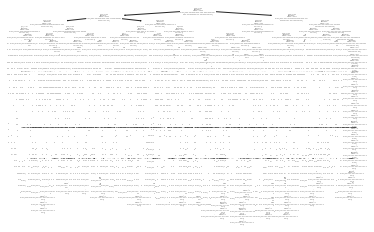

In [272]:
plt.figure()
tree.plot_tree(dtc)
plt.savefig("range_plots/tree.p", format="eps", bbox_inches = "tight")

In [7]:
rf = RandomForestClassifier(max_depth=5, random_state=0)
rf.fit(x_train, y_train)
print(100*(rf.predict(x_test) == y_test).mean())

55.630689546928956


In [8]:
clf = MLPClassifier(solver="adam", activation="logistic",alpha=1e-5, hidden_layer_sizes=(5,))
clf.fit(x_train, y_train)
print(100*(clf.predict(x_test) == y_test).mean())

79.04677199958145


/home/jaoi/anaconda3/envs/rufus/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [250]:
epochs = 2
for epoch in range(epochs):
    neg_cuda_tm2.fit(x_train, y_train)
    acc = 100*(neg_cuda_tm2.predict(x_test) == y_test).mean()
    print("tm2")
    print("Epoch {} s {} Accuracy tm:".format(epoch, s_param), acc)
    neg_cuda_tm3.fit(x_train, y_train)
    acc = 100*(neg_cuda_tm3.predict(x_test) == y_test).mean()
    print("tm3")
    print("Epoch {} s {} Accuracy tm:".format(epoch, s_param), acc)

tm2
Epoch 0 s 40.400000000000006 Accuracy tm: 74.91367583969864
tm3
Epoch 0 s 40.400000000000006 Accuracy tm: 74.60761745317568
tm2
Epoch 1 s 40.400000000000006 Accuracy tm: 78.44904258658575
tm3
Epoch 1 s 40.400000000000006 Accuracy tm: 78.47127759757247


In [10]:
literals = ['1. card', '2. card', '3. card', 'cards to aquire', 'final bid', 'final can bid', 'final coins', 'final order', 'final pass score',
            'final tot score', 'next bid', 'next can bid', 'next coins', 'next order', 'next pass score', 'next tot score', 'self bid', 'self coins',
            'self order', 'self pass score', 'self tot score', 'stack card', 'std bit']
def group_literals(literals):
    groups = {
    "cards": [],
    "orders": [],
    "scores": [],
    "bids": [],
    "coins": [],
    "aquire": [],
    "bina": []
    }
    for literal in literals:
        if literal.endswith("card"):
            groups["cards"].append(literal)
        elif literal.endswith("order"):
            groups["orders"].append(literal)
        elif literal.endswith("score"):
            groups["scores"].append(literal)
        elif literal.endswith("bid") and "can" not in literal:
            groups["bids"].append(literal)
        elif literal.endswith("coins"):
            groups["coins"].append(literal)
        elif "aquire" in literal:
            groups["aquire"].append(literal)
        else:
            groups["bina"].append(literal)
            
    return groups

groups = group_literals(literals)
len_values = [15, 3, 62, 18, 18, 4, 1]
groups_and_value = list(zip(groups.keys(), groups.values(), len_values))
groups_and_value

[('cards', ['1. card', '2. card', '3. card', 'stack card'], 15),
 ('orders', ['final order', 'next order', 'self order'], 3),
 ('scores',
  ['final pass score',
   'final tot score',
   'next pass score',
   'next tot score',
   'self pass score',
   'self tot score'],
  62),
 ('bids', ['final bid', 'next bid', 'self bid'], 18),
 ('coins', ['final coins', 'next coins', 'self coins'], 18),
 ('aquire', ['cards to aquire'], 4),
 ('bina', ['final can bid', 'next can bid', 'std bit'], 1)]

In [14]:
def get_name_of_feature_from_cum_4_rounds(feature_nr):
    total_features = 556
    feature_nr = int(feature_nr)
    money_len = 18
    score_len = 62
    order_len = 3
    stack_len = 15
    board_card_len = 15
    can_bid_len = 1
    leading_bits = [1, 2, 3]
    money_values = list(range(1, 19))
    score_values = list(range(1, 63))
    stack_values = list(range(1, 16))
    board_values = list(range(1, 16))
    cards_left_values = list(range(1, 5))
    
    # for self
    if feature_nr in list(range(money_len)):
        return "self coins {}".format(money_values[feature_nr])
    elif feature_nr in list(range(money_len, money_len+score_len)):
        return "self tot score {}".format(score_values[feature_nr - money_len]) 
    elif feature_nr in list(range(money_len+score_len, money_len*2 + score_len)):
        return "self bid {}".format(money_values[feature_nr - (money_len+score_len)])
    elif feature_nr in list(range(money_len*2 + score_len, money_len*2 + score_len*2)):
        return "self pass score {}".format(score_values[feature_nr - (money_len*2 + score_len)])
    elif feature_nr in list(range(money_len*2 + score_len*2, money_len*2 + score_len*2 + order_len)):
        return "self order {}".format(leading_bits[feature_nr - (money_len*2 + score_len*2)])
    
    # for next player
    elif feature_nr in list(range(money_len*2 + score_len*2 + order_len, money_len*3 + score_len*2 + order_len)):
        return "next coins {}".format(money_values[feature_nr - (money_len*2 + score_len*2 + order_len)]) 
    elif feature_nr in list(range(money_len*3 + score_len*2 + order_len, money_len*3 + score_len*3 + order_len)):
        return "next tot score {}".format(score_values[feature_nr - (money_len*3 + score_len*2 + order_len)])
    elif feature_nr in list(range(money_len*3 + score_len*3 + order_len, money_len*4 + score_len*3 + order_len)):
        return "next bid {}".format(money_values[feature_nr - (money_len*3 + score_len*3 + order_len)])
    elif feature_nr in list(range(money_len*4 + score_len*3 + order_len, money_len*4 + score_len*4 + order_len)):
        return "next pass score {}".format(score_values[feature_nr - (money_len*4 + score_len*3 + order_len)])
    elif feature_nr in list(range(money_len*4 + score_len*4 + order_len, money_len*4 + score_len*4 + order_len*2)):
        return "next order {}".format(leading_bits[feature_nr - (money_len*4 + score_len*4 + order_len)])
    elif feature_nr == (money_len*4 + score_len*4 + order_len*2):
        return "next can bid  "
    
    # for final player
    elif feature_nr in list(range(money_len*4 + score_len*4 + order_len*2 + can_bid_len, money_len*5 + score_len*4 + order_len*2 + can_bid_len)):
        return "final coins {}".format(money_values[feature_nr - (money_len*4 + score_len*4 + order_len*2 + can_bid_len)])
    elif feature_nr in list(range(money_len*5 + score_len*4 + order_len*2 + can_bid_len, money_len*5 + score_len*5 + order_len*2 + can_bid_len)):
        return "final tot score {}".format(score_values[feature_nr - (money_len*5 + score_len*4 + order_len*2 + can_bid_len)])
    elif feature_nr in list(range(money_len*5 + score_len*5 + order_len*2 + can_bid_len, money_len*6 + score_len*5 + order_len*2 + can_bid_len)):
        return "final bid {}".format(money_values[feature_nr - (money_len*5 + score_len*5 + order_len*2 + can_bid_len)])
    elif feature_nr in list(range(money_len*6 + score_len*5 + order_len*2 + can_bid_len, money_len*6 + score_len*6 + order_len*2 + can_bid_len)):
        return "final pass score {}".format(score_values[feature_nr - (money_len*6 + score_len*5 + order_len*2 + can_bid_len)])
    elif feature_nr in list(range(money_len*6 + score_len*6 + order_len*2 + can_bid_len, money_len*6 + score_len*6 + order_len*3 + can_bid_len)):
        return "final order {}".format(leading_bits[feature_nr - (money_len*6 + score_len*6 + order_len*2 + can_bid_len)])
    elif feature_nr == (money_len*6 + score_len*6 + order_len*3 + can_bid_len):
        return "final can bid  "
    
    # boardstuff 
    elif feature_nr in list(range(money_len*6 + score_len*6 + order_len*3 + can_bid_len*2, money_len*6 + score_len*6 + order_len*3 + stack_len + can_bid_len*2)):
        return "stack card {}".format(stack_values[feature_nr - (money_len*6 + score_len*6 + order_len*3 + can_bid_len*2)]) 
    elif feature_nr in list(range(money_len*6 + score_len*6 + order_len*3 + stack_len + can_bid_len*2, money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len + can_bid_len*2)):
        return "1. card {}".format(board_values[feature_nr - (money_len*6 + score_len*6 + order_len*3 + stack_len + can_bid_len*2)])
    elif feature_nr in list(range(money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len + can_bid_len*2, money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*2 + can_bid_len*2)):
        return "2. card {}".format(board_values[feature_nr - (money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len + can_bid_len*2)])
    elif feature_nr in list(range(money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*2 + can_bid_len*2, money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*3 + can_bid_len*2)):
        return "3. card {}".format(board_values[feature_nr - (money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*2 + can_bid_len*2)])
    elif feature_nr == money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*3 + can_bid_len*2:
        return "std bit  "
    elif feature_nr in list(range(money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*3 + can_bid_len*2 + 1, money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*3 + can_bid_len*2 + 1 + 4)):
        return "cards to aquire {}".format(cards_left_values[feature_nr - (money_len*6 + score_len*6 + order_len*3 + stack_len + board_card_len*3 + can_bid_len*2 + 1)])
    
    

In [15]:
def double(lst):
    try:
        return [i+556 for i in lst]
    except TypeError:
        print(lst)

def reduce_neg_coalesce_literals_4r(tm, clause):
    # negation
    # else:
    # l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
    own_money = list(range(18))
    high_own_money = (0, "")
    neg_own_money = (0, "")
    own_total_score = list(range(18, 80))
    high_own_total_score = (0, "")
    neg_own_total_score = (0, "")
    own_bid = list(range(80, 98))
    high_own_bid = (0, "")
    neg_own_bid = (0, "")
    own_pass_score = list(range(98, 160))
    high_own_pass_score = (0, "")
    neg_own_pass_score = (0, "")
    own_pass_order = list(range(160, 163))
    
    next_coins = list(range(163, 181))
    high_next_coins = (0, "")
    neg_next_coins = (0, "")
    next_tot_score = list(range(181, 243))
    high_next_tot_score = (0, "")
    neg_next_tot_score = (0, "")
    next_bid = list(range(243, 261))
    high_next_bid = (0, "")
    neg_next_bid = (0, "")
    next_pass_score = list(range(261, 323))
    high_next_pass_score = (0, "")
    neg_next_pass_score = (0, "")
    next_order = list(range(323, 326))
    next_can_bid = 326

    final_coins = list(range(327, 345))
    high_final_coins = (0, "")
    neg_final_coins = (0, "")
    final_tot_score = list(range(345, 407))
    high_final_tot_score = (0, "")
    neg_final_tot_score = (0, "")
    final_bid = list(range(407, 425))
    high_final_bid = (0, "")
    neg_final_bid = (0, "")
    final_pass_score = list(range(425, 487))
    high_final_pass_score = (0, "")
    neg_final_pass_score = (0, "")
    final_order = list(range(487, 490))
    final_can_bid = 490

    stack_card = list(range(491, 506))
    board_c1 = list(range(506, 521))
    high_board_c1 = (0, "")
    neg_board_c1 = (0, "")
    board_c2 = list(range(521, 536))
    high_board_c2 = (0, "")
    neg_board_c2 = (0, "")
    board_c3 = list(range(536, 551))
    high_board_c3 = (0, "")
    neg_board_c3 = (0, "")
    std_bit = 551
    cards_to_aquire = list(range(552, 556))
    high_cards_to_aquire = (0, "")
    neg_cards_to_aquire = (0, "")
    

    
    number_of_features = 556
    l = []
    for k in range(number_of_features*2):
        if tm.get_ta_action(clause, k) == 1 and (k in own_money or k in double(own_money)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k) 
                if int(name[-2:]) > high_own_money[0]:
                    high_own_money = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_own_money[0]:
                    neg_own_money = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and (k in own_total_score or k in double(own_total_score)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_own_total_score[0]:
                    high_own_total_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_own_total_score[0]:
                    neg_own_total_score = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and (k in own_bid or k in double(own_bid)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_own_bid[0]:
                    high_own_bid = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_own_bid[0]:
                    neg_own_bid = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and (k in own_pass_score or k in double(own_pass_score)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_own_pass_score[0]:
                    high_own_pass_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_own_pass_score[0]:
                    neg_own_pass_score = (int(name[-2:]), name)
                    
        # find out what to do about this one!
        elif tm.get_ta_action(clause, k) == 1 and (k in own_pass_order or k in double(own_pass_order)):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            # else:
            #     l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
                
                  
        elif tm.get_ta_action(clause, k) == 1 and (k in next_coins or k in double(next_coins)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_next_coins[0]:
                    high_next_coins = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_next_coins[0]:
                    neg_next_coins = (int(name[-2:]), name)
                    
            
        elif tm.get_ta_action(clause, k) == 1 and (k in next_tot_score or k in double(next_tot_score)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_next_tot_score[0]:
                    high_next_tot_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_next_tot_score[0]:
                    neg_next_tot_score = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and (k in next_bid or k in double(next_bid)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_next_bid[0]:
                    high_next_bid = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_next_bid[0]:
                    neg_next_bid = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and (k in next_pass_score or k in double(next_pass_score)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_next_pass_score[0]:
                    high_next_pass_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_next_pass_score[0]:
                    neg_next_pass_score = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and (k in next_order or k in double(next_order)):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            # else:
            #     l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
                
        elif tm.get_ta_action(clause, k) == 1 and (k == next_can_bid or k == next_can_bid + number_of_features):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            else:
                l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))        
                
        elif tm.get_ta_action(clause, k) == 1 and (k in final_coins or k in double(final_coins)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_final_coins[0]:
                    high_final_coins = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_final_coins[0]:
                    neg_final_coins = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and (k in final_tot_score or k in double(final_tot_score)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_final_tot_score[0]:
                    high_final_tot_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_final_tot_score[0]:
                    neg_final_tot_score = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and (k in final_bid or k in double(final_bid)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_final_bid[0]:
                    high_final_bid = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_final_bid[0]:
                    neg_final_bid = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and (k in final_pass_score or k in double(final_pass_score)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_final_pass_score[0]:
                    high_final_pass_score = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_final_pass_score[0]:
                    neg_final_pass_score = (int(name[-2:]), name)
        elif tm.get_ta_action(clause, k) == 1 and (k in final_order or k in double(final_order)):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            # else:
                # l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
        
        elif tm.get_ta_action(clause, k) == 1 and (k == final_can_bid or k == final_can_bid + number_of_features):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            else:
                l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
        
        elif tm.get_ta_action(clause, k) == 1 and (k in stack_card or k in double(stack_card)):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            else:
                l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
        
        elif tm.get_ta_action(clause, k) == 1 and (k in board_c1 or k in double(board_c1)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_board_c1[0]:
                    high_board_c1 = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_board_c1[0]:
                    neg_board_c1 = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and (k in board_c2 or k in double(board_c2)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_board_c2[0]:
                    high_board_c2 = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_board_c2[0]:
                    neg_board_c2 = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and (k in board_c3 or k in double(board_c3)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_board_c3[0]:
                    high_board_c3 = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_board_c3[0]:
                    neg_board_c3 = (int(name[-2:]), name)
                    
        elif tm.get_ta_action(clause, k) == 1 and (k == std_bit or k == std_bit + number_of_features):
            if k < number_of_features:
                l.append(get_name_of_feature_from_cum_4_rounds(k))
            else:
                l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
                
        elif tm.get_ta_action(clause, k) == 1 and (k in cards_to_aquire or k in double(cards_to_aquire)):
            if k < number_of_features:
                name = get_name_of_feature_from_cum_4_rounds(k)
                if int(name[-2:]) > high_cards_to_aquire[0]:
                    high_cards_to_aquire = (int(name[-2:]), name)
            else:
                name = "¬" + get_name_of_feature_from_cum_4_rounds(k - number_of_features)
                if int(name[-2:]) > neg_cards_to_aquire[0]:
                    neg_cards_to_aquire = (int(name[-2:]), name)
                    
        # else:
        #     if k < number_of_features:
        #         l.append(get_name_of_feature_from_cum_4_rounds(k))
            # else:
            #     l.append("¬"+get_name_of_feature_from_cum_4_rounds(k-number_of_features))
        
    
    l.append(high_own_money[1]) if high_own_money[1] != "" else None
    l.append(neg_own_money[1]) if neg_own_money[1] != "" else None
    l.append(high_own_bid[1]) if high_own_bid[1] != "" else None
    l.append(neg_own_bid[1]) if neg_own_bid[1] != "" else None
    l.append(high_own_total_score[1]) if high_own_total_score[1] != "" else None
    l.append(neg_own_total_score[1]) if neg_own_total_score[1] != "" else None
    l.append(high_own_pass_score[1]) if high_own_pass_score[1] != "" else None
    l.append(neg_own_pass_score[1]) if neg_own_pass_score[1] != "" else None
    
    l.append(high_next_coins[1]) if high_next_coins[1] != "" else None
    l.append(neg_next_coins[1]) if neg_next_coins[1] != "" else None
    l.append(high_next_tot_score[1]) if high_next_tot_score[1] != "" else None
    l.append(neg_next_tot_score[1]) if neg_next_tot_score[1] != "" else None
    l.append(high_next_bid[1]) if high_next_bid[1] != "" else None
    l.append(neg_next_bid[1]) if neg_next_bid[1] != "" else None
    l.append(high_next_pass_score[1]) if high_next_pass_score[1] != "" else None
    l.append(neg_next_pass_score[1]) if neg_next_pass_score[1] != "" else None
    
    l.append(high_final_coins[1]) if high_final_coins[1] != "" else None
    l.append(neg_final_coins[1]) if neg_final_coins[1] != "" else None
    l.append(high_final_tot_score[1]) if high_final_tot_score[1] != "" else None
    l.append(neg_final_tot_score[1]) if neg_final_tot_score[1] != "" else None
    l.append(high_final_bid[1]) if high_final_bid[1] != "" else None
    l.append(neg_final_bid[1]) if neg_final_bid[1] != "" else None
    l.append(high_final_pass_score[1]) if high_final_pass_score[1] != "" else None
    l.append(neg_final_pass_score[1]) if neg_final_pass_score[1] != "" else None
    
    l.append(high_board_c1[1]) if high_board_c1[1] != "" else None
    l.append(neg_board_c1[1]) if neg_board_c1[1] != "" else None
    l.append(high_board_c2[1]) if high_board_c2[1] != "" else None
    l.append(neg_board_c2[1]) if neg_board_c2[1] != "" else None
    l.append(high_board_c3[1]) if high_board_c3[1] != "" else None
    l.append(neg_board_c3[1]) if neg_board_c3[1] != "" else None
    l.append(high_cards_to_aquire[1]) if high_cards_to_aquire[1] != "" else None
    l.append(neg_cards_to_aquire[1]) if neg_cards_to_aquire[1] != "" else None
    
    l = [i for i in l if i != ""]
    return l

In [218]:
c_out = neg_cuda_tm.transform(x_test[10].reshape(1, -1))
clauses_out = np.where(c_out == 1)[1].astype(int)

def get_complete_interval(tm, clauses, literals):
    intervals = {}
    for literal in literals[0]:
        # print(literal)
        neg_interval = np.zeros(literals[1]+1)
        pos_interval = np.zeros(literals[1]+1)
        
        for clause in clauses:
            # print(sorted(literals))
            reduced = reduce_neg_coalesce_literals_4r(tm, clause)
            extracted_reduced = [result for result in reduced if literal in result]

            for ex in extracted_reduced:
                try:
                    if ex.startswith(literal):
                        pos_interval[int(ex[-2:])] += 1
                    elif ex.startswith("¬"+literal):
                        neg_interval[int(ex[-2:])] += 1
                except ValueError:
                    if ex.startswith("¬"+literal):
                        neg_interval[0] += 1
                    elif ex.startswith(literal):
                        pos_interval[0] += 1
                # else:
            #     interval_dict[literal_type][int(ex[-2:])] += 1
        intervals[literal] = pos_interval
        intervals["¬"+literal] = neg_interval
    return intervals

def get_complete_reduced_interval(tm, clauses, literals):
    intervals = {}
    for literal in literals[0]:
        # print(literal)
        neg_interval = np.zeros(literals[1]+1)
        pos_interval = np.zeros(literals[1]+1)
        
        for clause in clauses:
            # print(sorted(literals))
            reduced = reduce_neg_coalesce_literals_4r(tm, clause)
            # extracted_reduced = [result for result in reduced if literal in result]
            
            for result in reduced:
                if literal in result:
                    try:
                        if result.startswith(literal):
                            pos_interval[int(result[-2:])] += 1
                        elif result.startswith("¬"+literal):
                            neg_interval[int(result[-2:])] += 1
                    except ValueError:
                        # print("something was wrong with: ", result)
                        if result.startswith("¬"+literal):
                            neg_interval[0] += 1
                        elif result.startswith(literal):
                            pos_interval[0] += 1

        intervals[literal] = pos_interval
        intervals["¬"+literal] = neg_interval
    return intervals

In [268]:
b4 = [14, 8, 7]
example4 = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
example4 = np.delete(example4, self_can_bet_index)

b3 = [10, 3, 2]
example3 = np.array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
example3 = np.delete(example3, self_can_bet_index)

In [99]:

c_out = neg_cuda_tm.transform(x_test[10].reshape(1, -1))
clauses_out = np.where(c_out == 1)[1].astype(int)
mw = neg_cuda_tm.weight_banks[neg_cuda_tm.predict(x_test[1001].reshape(-1, 1))[0]].get_weights()
new_c_out = mw[clauses_out]
clauses_out = clauses_out[new_c_out > 0]
clauses_out

array([ 170,  215,  355,  426,  453,  707, 1300, 1478, 1733, 1878, 1969,
       2227, 2837, 3103, 3131, 3540, 3661, 3744, 4302, 4361, 4721, 4987,
       5103, 5219, 5260, 5360, 5387, 5622, 5653, 5866, 5900, 5902, 6034,
       6089, 6123, 6290, 6549, 6640, 6782, 6815, 7240, 7362, 7532, 7704])

In [102]:
def create_plots_from_data_with_y(tm, ex, y):
    c_out = tm.transform(ex.reshape(1, -1))
    clauses_out = np.where(c_out == 1)[1].astype(int)
    mw = tm.weight_banks[tm.predict(ex.reshape(-1, 1))[0]].get_weights()
    new_c_out = mw[clauses_out]
    clauses_out = clauses_out[new_c_out > 0]
    grouped_intervals = defaultdict(list)
    for group in groups_and_value:
        grouped_intervals[group[0]] = get_complete_reduced_interval(tm, clauses_out, (group[1], group[2]))
    return grouped_intervals

ex_groups = create_plots_from_data_with_y(neg_cuda_tm, x_test[1001], neg_cuda_tm.predict(x_test[1001].reshape(-1, 1))[0])

132
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬final can bid  
something was wrong with:  ¬

In [222]:
ex4_groups = create_plots_from_data_with_y(neg_cuda_tm, example4, neg_cuda_tm.predict(example4.reshape(-1, 1))[0])

50


In [269]:
ex3_groups = create_plots_from_data_with_y(neg_cuda_tm, example3, neg_cuda_tm.predict(example3.reshape(-1, 1))[0])

45


In [149]:
pprint.pprint(ex_groups)
print(neg_cuda_tm.literal_clause_frequency().shape)

defaultdict(<class 'list'>,
            {'aquire': {'cards to aquire': array([0., 0., 0., 0., 0.]),
                        '¬cards to aquire': array([ 0.,  6., 18., 30., 63.])},
             'bids': {'final bid': array([ 0., 42.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.]),
                      'next bid': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.]),
                      'self bid': array([ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.]),
                      '¬final bid': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  5.,  2.,  0.,  1.,
        2.,  4., 12., 12., 27., 63.]),
                      '¬next bid': array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  2.,  2.,
        5.,  6.,  6., 21., 28., 58.]),
                      '¬self bid': array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  1.,
    

dict_keys(['cards', 'orders', 'scores', 'bids', 'coins', 'aquire', 'bina'])
2
3182
556.0


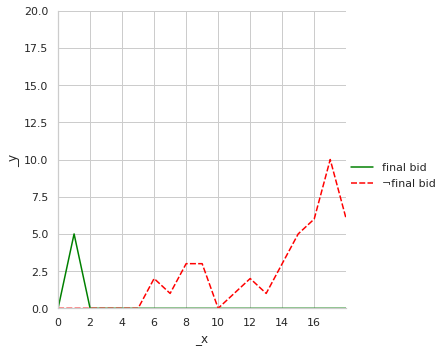

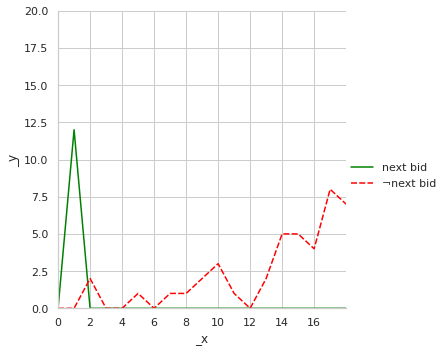

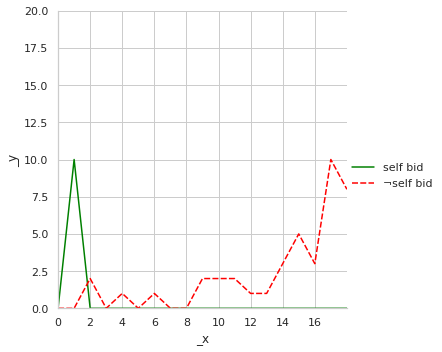

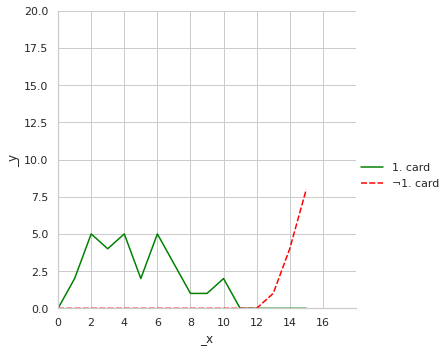

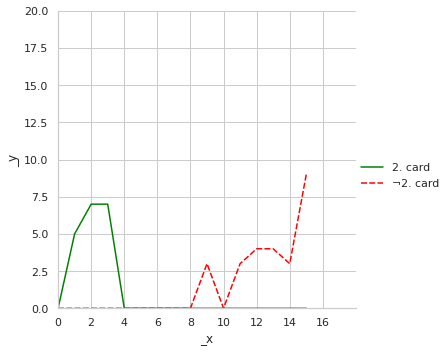

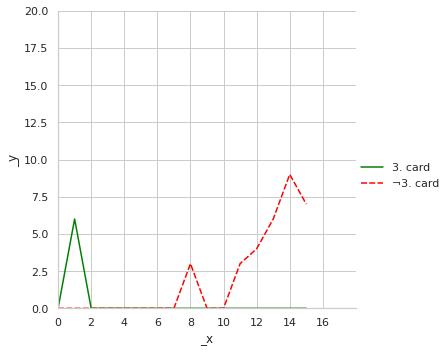

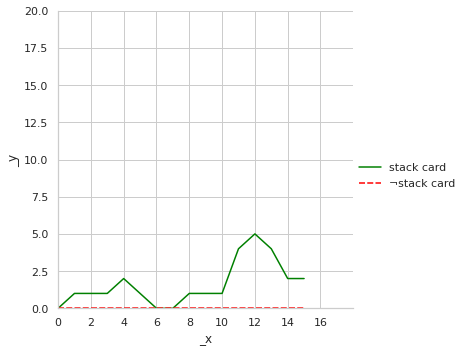

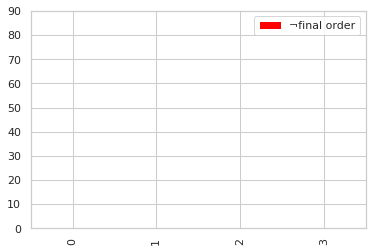

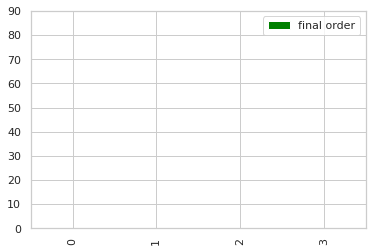

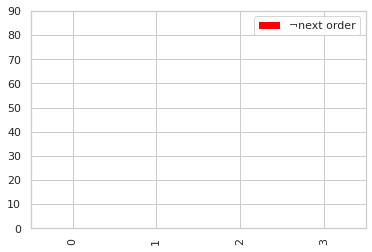

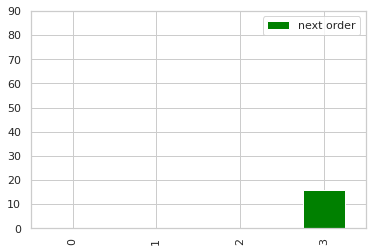

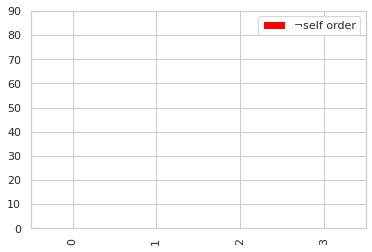

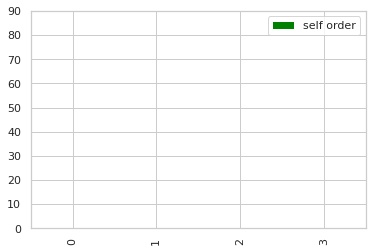

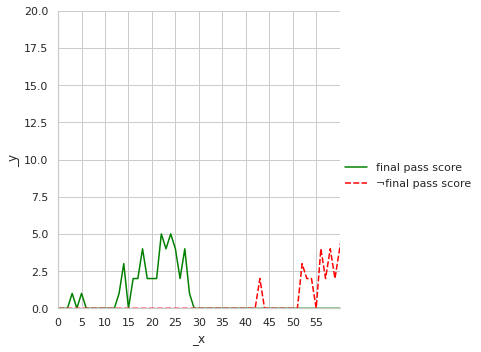

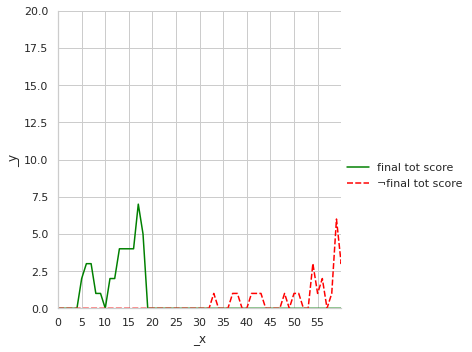

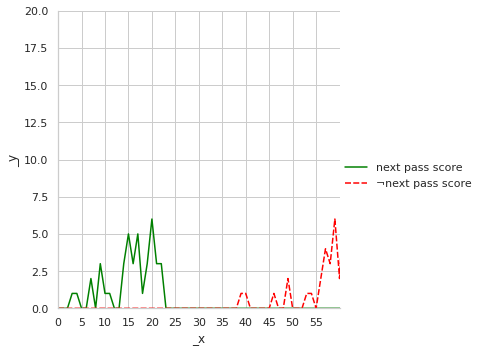

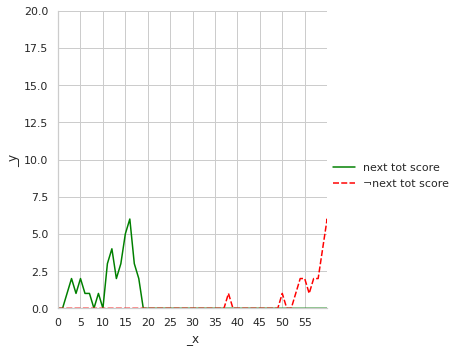

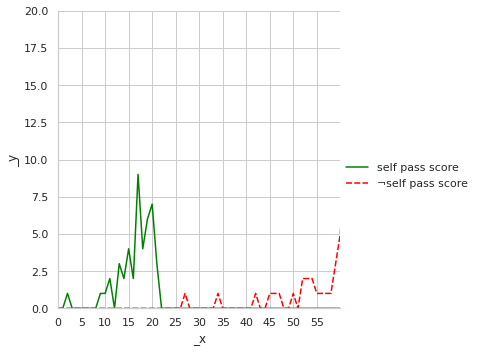

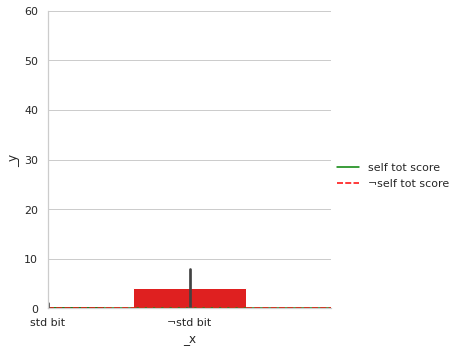

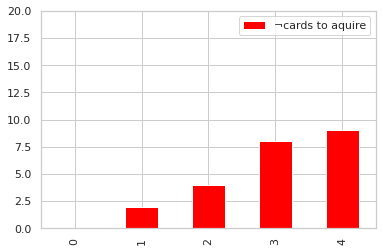

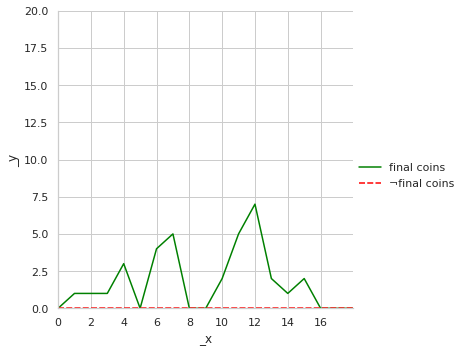

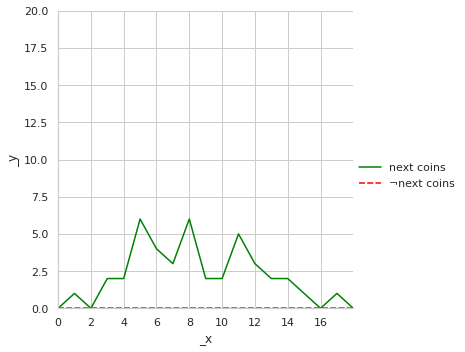

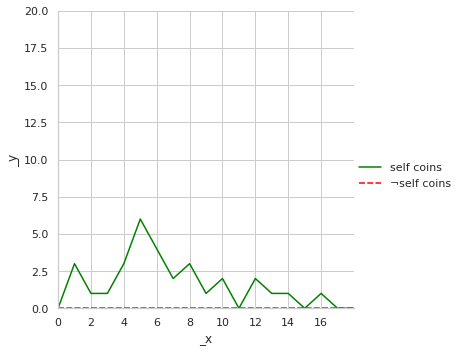

In [271]:
# sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints1["bids"].items()}), kind="line")
def spit_out_interval(data, literal):
    result_dict = {}
    for k,v in data.items():
        if k == literal or k == "¬"+literal:
            result_dict[k] = v
    return pd.DataFrame(result_dict)

def show_coin_plot(data, literal):
    
    d = spit_out_interval(data, literal)
    sns.set(style="whitegrid")
    # fig, ax = plt.subplots()
    sns.relplot(data=d, kind="line", palette=["green", "red"])
    plt.ylim(0, 20)
    plt.xlim(0, 18)
    plt.xticks(range(0, 18, 2))
    # plt.show()
    plt.savefig("range_plots/"+literal + ".png")
    
    
def show_binary_plot(data, literal):
    d = spit_out_interval(data, literal)
    sns.set(style="whitegrid")
    # fig, ax = plt.subplots()
    sns.barplot(data=d, palette=["green", "red"])
    plt.ylim(0, 60)
    plt.xlim(0, 2)
    # plt.xticks(range(0, 18, 2))
    # plt.show()
    plt.savefig("range_plots/"+literal + ".png")

    

def show_score_plot(data, literal):
    d = spit_out_interval(data, literal)
    sns.set(style="whitegrid")
    # fig, ax = plt.subplots()
    sns.relplot(data=d, kind="line", palette=["green", "red"])
    plt.ylim(0, 20)
    plt.xlim(0, 60)
    plt.xticks(range(0, 60, 5))
    # plt.show()
    plt.savefig("range_plots/"+literal + ".png")
    
    
def show_order_plot(data, literal):
    d = spit_out_interval(data, literal)
    print(data, d)
    
    sns.set(style="whitegrid")
    # fig, ax = plt.subplots()
    sns.barplot(data=d, palette=["green", "red"])
    plt.ylim(0, 90)
    # plt.xlim(0, 4)
    plt.xticks(range(0, 4, 1))
    # plt.show()
    plt.savefig("range_plots/"+literal + ".png")
    

def plot_cards(data):
    for literal in groups["cards"]:
        show_coin_plot(data["cards"], literal)
        

def plot_binaries(data):
    for literal in groups["bina"]:
        show_binary_plot(data["bina"], literal)
        
        
def plot_scores(data):
    for literal in groups["scores"]:
        show_score_plot(data["scores"], literal)

        
def plot_bids(data):
    for literal in groups["bids"]:
        show_coin_plot(data["bids"], literal)


def plot_coins(data):
    for literal in groups["coins"]:
        show_coin_plot(data["coins"], literal)


def plot_orders(data):
    for literal in groups["orders"]:
        pd.DataFrame({"¬"+literal: spit_out_interval(data["orders"], literal)["¬"+literal]}).plot(kind="bar", color="red")
        plt.ylim(0, 90)
        plt.show()
        pd.DataFrame({literal: spit_out_interval(data["orders"], literal)[literal]}).plot(kind="bar", color="green")
        plt.ylim(0, 90) 
        plt.show()
        # plt.savefig("range_plots/orders")
        
        
        
        
def plot_aquire(data):
    for literal in groups["aquire"]:
        # pd.DataFrame({"cards to aquire": spit_out_interval(data["aquire"], literal)["cards to aquire"]}).plot(kind="bar", color="green")
        # plt.ylim(0, 90)
        # plt.show()
        s = pd.DataFrame({"¬cards to aquire": spit_out_interval(data["aquire"], literal)["¬cards to aquire"]}).plot(kind="bar", color="red")
        fig = s.get_figure()
        plt.ylim(0, 20)
        plt.show()
        fig.savefig("range_plots/"+"cards to aquire.png")
        
        
# show_coin_plot(int1, "3. card")
# show_coin_plot(int1, "2. card")
# show_coin_plot(int1, "1. card")
# show_coin_plot(int1, "stack card")
# show_coin_plot(ex_groups["bids"], "self bid")
# show_coin_plot(ex_groups["bids"], "final bid")
# show_coin_plot(ex_groups["coins"], "final coins")
# show_coin_plot(ex_groups["cards"], "stack card")
# show_score_plot(ex_groups["scores"], "final tot score")
# show_binary_plot(ex_groups["bina"], "final can bid")
# show_binary_plot(ex_groups["bina"], "next can bid")
print(groups.keys())
print(neg_cuda_tm.predict(example3.reshape(-1, 1))[0])
print(neg_cuda_tm.literal_clause_frequency().max())
print(1112/2)
plot_bids(ex3_groups)
plot_cards(ex3_groups)
plot_orders(ex3_groups)
plot_scores(ex3_groups)
plot_binaries(ex3_groups)
plot_aquire(ex3_groups)
plot_coins(ex3_groups)




# sns.relplot(data=pd.DataFrame({k: v for k,v in pos_ints1["bids"].items()}), kind="line")

In [221]:
print(neg_cuda_tm.predict(example4)[0])
for clas in range(len(neg_cuda_tm.weight_banks)):
    clauses_out = neg_cuda_tm.transform(example4)
    mw = neg_cuda_tm.weight_banks[clas].get_weights()
    new_c_out =clauses_out * mw
    print(clas, new_c_out.sum())
    clauses_out = clauses_out[new_c_out > 0]

4
0 -1047
1 -2381
2 -2531
3 173
4 1486
5 -1538
6 -1477
7 -2977
8 -3698
9 -3599
10 -3531
11 -3048
12 -3001
13 -3064
14 -2975
15 -3066
16 -3041
